In [1]:
import cv2, os
import openpyxl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from skimage.transform import resize

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
base_path = r'input\CDD-CESM\images'

img = list()

for folder in os.listdir(base_path):
    full_path = os.path.join(base_path, folder)
    for filename in os.listdir(full_path):
        img.append(cv2.imread(os.path.join(full_path, filename), cv2.IMREAD_GRAYSCALE))
    
img = np.array(img)

C:\Users\achib\AppData\Local\Temp\ipykernel_17068\4092076473.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img = np.array(img)


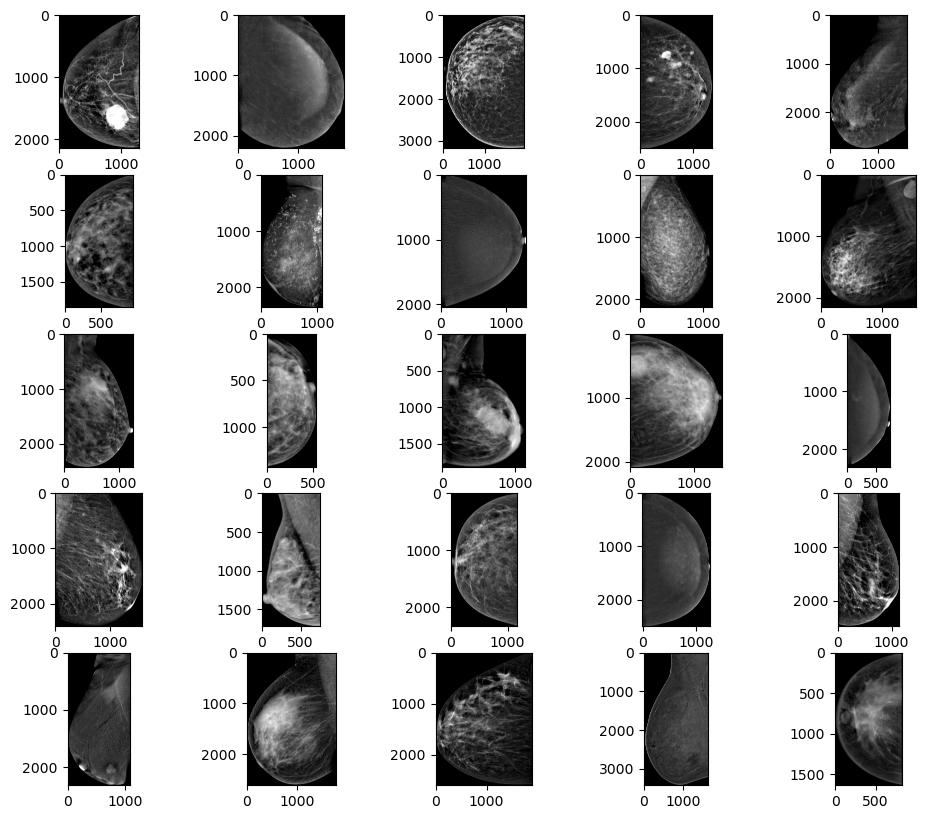

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))

for i in range(5):
    for j in range(5):
        axs[i, j].imshow(img[np.random.randint(len(img))], cmap='gray')

### Data Analysis

In [5]:
label_path = r'input\CDD-CESM\Radiology manual annotations.xlsx'

sheet_names = openpyxl.load_workbook(label_path).sheetnames
sheet_names

['all',
 'mass_description',
 'distortion',
 'postoperative',
 'postneoajuvant chemotherapy',
 'asymmetry',
 'calcifications',
 'mass enhancement_description',
 'nonmass enhancement_description']

In [6]:
def read_image(file_name, label, resize=False, shape=None):
    path = os.path.join(base_path, label, file_name)
    
    img = None
    
    if os.path.exists(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        raise Exception(f"FileNotFound: {file_name}")
    
    if resize:
        img = cv2.resize(img, shape)
    
    return img

In [7]:
IMG_SHAPE = (200, 200)

In [8]:
df = pd.read_excel(label_path, sheet_name='all')
file_names, labels = [x.strip() + '.jpg' for x in df['Image_name'].values], df['Pathology Classification/ Follow up'].values

X = list()
y = list()
for name, label in zip(file_names, labels):
    try:
        x = read_image(name, label, resize=True, shape=IMG_SHAPE)
    except:
        continue
    y.append(label)
    X.append(x)
X = np.array(X)
y = np.array(y)
(X.shape, y.shape)

((2001, 200, 200), (2001,))

In [9]:
y_map = {
    'Normal': 0,
    'Benign': 1,
    'Malignant': 2
}

y = np.array([y_map[x] for x in y])

In [10]:
X = X.reshape(X.shape[0], IMG_SHAPE[0], IMG_SHAPE[1], 1)
X = X / 255.0

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

### Classifier Model

In [12]:
IN = Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 1))

### ResNet50

In [13]:
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=IN,
    input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 1),
    pooling='avg',
    classes=3,
)

optimizer = SGD(.001, momentum=.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=1)

44/44 [==============================] - 31s 512ms/step - loss: 1.1598 - accuracy: 0.4079 - val_loss: 1.1186 - val_accuracy: 0.2845


In [15]:
pred = model.predict(X_test)
pred = [np.argmax(p) for p in pred]

acc = accuracy_score(y_test, pred)
print('Accuracy: ', round(acc, 4) * 100, '%')
print(classification_report(y_test, pred))

19/19 [==============================] - 3s 116ms/step
Accuracy:  28.449999999999996 %
              precision    recall  f1-score   support

           0       0.20      0.00      0.01       228
           1       0.29      1.00      0.44       170
           2       0.00      0.00      0.00       203

    accuracy                           0.28       601
   macro avg       0.16      0.33      0.15       601
weighted avg       0.16      0.28      0.13       601



C:\Users\achib\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\achib\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\achib\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


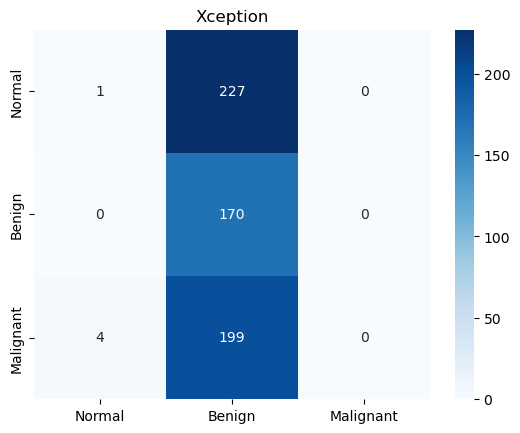

In [16]:
cm = confusion_matrix(y_test, pred)
plt.title('Xception')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xticks([.5, 1.5, 2.5], y_map.keys())
plt.yticks([.5, 1.5, 2.5], y_map.keys())
plt.show()